# Data Preprocessing to Transforming MPP data into images and predicting Transcription Rate (TS)

This notebook is ment to convert raw cell data from several wells into multichannel images (along with its corresponding mask, targets and metadata).

Data was taken from:
`/storage/groups/ml01/datasets/raw/20201020_Pelkmans_NascentRNA_hannah.spitzer/` and server `vicb-submit-01`. 

In the preprocessing done in this notebook. The objective of this preprocessing is to create a 'imaged' version of the MPP data.

The discretization of the channels (input_channels) and the selection of the target variable is done during the convertion into tensorflow dataset!

Considerations:
- NO discrimination of channels is done! All the channels are saved in the same order and all of them are also projected into a scalars and saved as target. However, if input_channels and output_channels are given in the parameters file, then the filtering of channels/targets is done during saving into disk.
- To avoid data duplication, the cell images for each well are saved right after the preprocessing and not at the end.
- NO train, val and test splitting is done here! That (and data normalization) is done during the creation of the TFDS.
- There are several ways of saving the images. This behaviour is defined by the parameter `img_saving_mode`:
    - **original_img**: save original cell image with its original size and shape (it could be recangular or squared). The drawback of this method is that images will be saved with different sizes and size ratios.
    - **original_img_and_squared**: save original cell image without fixed size but fixed shape (squared). Despite that the all images are saved with the same shape (squared), the drawback of this method is that images will be saved with different sizes.
    - **original_img_and_fixed_size**: save original cell image with fixed size and shape (squared). The drawback of this method is that if zoomin wants to be used as a data augmentation technique, then each image will need to be processed individually on the fly to avoid cropping the cell information.
    - **fixed_cell_size**: save image with a fixed size and shape (squared)maximizing the cell size within the image. This mean that up or down sampling may be needed. The drawback of this method is that the some distortion of the original data (image) is inevitable during up or down samplig (zoom in/out). There are several option for the up/down sampling (interpolation) which can be selected through the parameter `img_interpolation_method`. To see the complete list of available interpolation methods, please visit:<br>https://www.tensorflow.org/api_docs/python/tf/image/ResizeMethod
    

# 1.- Preparation

Load libraries:

In [1]:
# For Development and debugging:
# Reload modul without restarting the kernel
#%load_ext autoreload
#%autoreload 2

In [2]:
import numpy as np
import pandas as pd
# To display all the columns
pd.options.display.max_columns = None
import os
import sys
import matplotlib.pyplot as plt
import json
import math
import matplotlib.pyplot as plt
from datetime import datetime
import socket

# Set terminal output (to send mesages to the terminal stdout)
terminal_output = open('/dev/stdout', 'w')
print('Execution of Notebook started at {}'.format(datetime.now()), file=terminal_output)

Load external libraries:

In [3]:
# Load external libraries
if socket.gethostname() == 'hughes-machine':
    external_libs_path = '/home/hhughes/Documents/Master_Thesis/Project/workspace/libs'
else:
    external_libs_path= '/storage/groups/ml01/code/andres.becker/master_thesis/workspace/libs'
print('External libs path: \n'+external_libs_path, file=terminal_output)

if not os.path.exists(external_libs_path):
    msg = 'External library path {} does not exist!'.format(external_libs_path)
    raise Exception(msg)
    
# Add EXTERNAL_LIBS_PATH to sys paths (for loading libraries)
sys.path.insert(1, external_libs_path)
# Load external libraries
from pelkmans.mpp_data_V2 import MPPData as MPPData
from Utils import create_directory as create_directory
from Utils import print_stdout_and_log as print_stdout_and_log

Load Parameters:

In [4]:
# Do not touch the value of PARAMETERS_FILE!
# When this notebook is executed with jupyter-nbconvert (from script), 
# it will be replaced outomatically
PARAMETERS_FILE = '/home/hhughes/Documents/Master_Thesis/Project/workspace/scripts/Data_Preprocessing/Parameters/MppData_to_imgs_no_split_dummy.json'
#PARAMETERS_FILE = 'dont_touch_me-input_parameters_file'

if not os.path.exists(PARAMETERS_FILE):
    raise Exception('Parameter file {} does not exist!'.format(PARAMETERS_FILE))
    
# Open parameters
with open(PARAMETERS_FILE) as params_file:
    p = json.load(params_file)
    
# Save parameter file path and libs path
p['parameters_file_path'] = PARAMETERS_FILE
p['external_libs_path'] = external_libs_path

# Set some default parameters in case they are not given
if 'input_channels' not in p.keys():
    p['input_channels'] = None
    
if 'output_channels' not in p.keys():
    p['output_channels'] = None

for key in p.keys():
    print_stdout_and_log('{}: {}'.format(key, p[key]))

_comment: Project unichannel images into a scalar and save in metadata-
raw_data_dir: /data/Master_Thesis_data/Raw_data
dir_type: hannah
perturbations_and_wells: {'184A1_hannah_unperturbed': ['I09']}
output_pp_data_path: /data/Master_Thesis_data/datasets/184A1_hannah_imgs_no_split_dummy
output_pp_data_dir_name: data
log_file: /tmp/Convert_data_into_imgs_no_split.log
img_size: 224
images_dtype: float32
img_saving_mode: original_img_and_fixed_size
return_cell_size_ratio: 1
img_interpolation_method: nearest
subtract_background: 1
background_value: secondary_only_relative_normalisation.csv
add_cell_cycle_to_metadata: 1
cell_cycle_file: cell_cycle_classification.csv
add_well_info_to_metadata: 1
well_info_file: wells_metadata.csv
filter_criteria: ['is_border_cell', 'is_polynuclei_184A1', 'is_polynuclei_HeLa', 'cell_cycle']
filter_values: [1, 1, 1, 'NaN']
aggregate_output: avg
project_into_scalar: 1
parameters_file_path: /home/hhughes/Documents/Master_Thesis/Project/workspace/scripts/Data_Pre

Set logging:

In [5]:
# Set logging configuration
import logging
logging.basicConfig(
    filename=p['log_file'],
    filemode='w', 
    level=getattr(logging, 'INFO')
)
print_stdout_and_log('Parameters loaded from file:\n{}'.format(PARAMETERS_FILE))

Parameters loaded from file:
/home/hhughes/Documents/Master_Thesis/Project/workspace/scripts/Data_Preprocessing/Parameters/MppData_to_imgs_no_split_dummy.json


Set paths and Load external libraries:

In [6]:
# Load data path
DATA_DIR = p['raw_data_dir']
if not os.path.exists(DATA_DIR):
    raise Exception('Data path {} does not exist!'.format(DATA_DIR))
print_stdout_and_log('DATA_DIR: {}'.format(DATA_DIR))

# Create dirs to save data
outdir = p['output_pp_data_path']
create_directory(dir_path=outdir, clean_if_exist=False)

# Create directories to save images
output_data_path = os.path.join(outdir, p['output_pp_data_dir_name'])
create_directory(dir_path=output_data_path, clean_if_exist=True)

DATA_DIR: /data/Master_Thesis_data/Raw_data
Creating dir: /data/Master_Thesis_data/datasets/184A1_hannah_imgs_no_split_dummy
Warning! Directory /data/Master_Thesis_data/datasets/184A1_hannah_imgs_no_split_dummy/data already exist! Deleting...

Creating dir: /data/Master_Thesis_data/datasets/184A1_hannah_imgs_no_split_dummy/data


# 2.- Prepare selected data to process (wells and I/O channels)

Check available data (Perturbations and Wells):

In [7]:
print_stdout_and_log('Reading local available perturbations-wells...')
# Save available local Perturbations and Wells
perturbations = [per for per in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, per))]
local_data = {}
#print('Local available perturbations-wells:\n')
for per in perturbations:
    pertur_dir = os.path.join(DATA_DIR, per)
    wells = [w for w in os.listdir(pertur_dir) if os.path.isdir(os.path.join(pertur_dir, w))]
    #print('{}\n\t{}\n'.format(p, wells))
    local_data[per] = wells

Reading local available perturbations-wells...


Select Perturbations and its wells to process: 

In [8]:
msg = 'Local available perturbations-wells:\n{}'.format(local_data)
print(msg)
logging.debug(msg)

# In case you only want to load some specific perturbations and/or wells here:
#selected_data = {
#    '184A1_hannah_unperturbed': ['I11', 'I09'],
#    '184A1_hannah_TSA': ['J20', 'I16'],
#}

# Load perturbations-wells from parameters file
selected_data = p['perturbations_and_wells']
# How many wlls will be processed?
n_wells = 0
for key in list(selected_data.keys()):
    n_wells += len(selected_data[key])

print('\nSelected perturbations-wells:\n{}'.format(selected_data))

#Generate and save data dirs
data_dirs = []
for per in selected_data.keys():
    for w in selected_data[per]:
        d = os.path.join(DATA_DIR, per, w)
        data_dirs.append(d)
        if not os.path.exists(d):
            msg = '{} does not exist!\nCheck if selected_data contain elements only from local_data dict.'.format(d)
            raise Exception(msg)
p['data_dirs'] = data_dirs

Local available perturbations-wells:
{'184A1_hannah_DMSO': ['J16', 'I14'], '184A1_hannah_unperturbed': ['I09', 'I11', 'I13', 'J10', 'J12', 'J18']}

Selected perturbations-wells:
{'184A1_hannah_unperturbed': ['I09']}


# 3.- Process data and save into disk as images

Process data:

In [9]:
msg = 'Starting processing of {} wells...'.format(n_wells)
logging.info(msg)

metadata_df = pd.DataFrame()
channels_df = pd.DataFrame()

for w, data_dir in enumerate(p['data_dirs'], 1):
    msg = 'Processing well {}/{} from dir {}...'.format(w, n_wells, data_dir)
    logging.info(msg)
    print('\n\n'+msg)
    # Load data as an MPPData object
    mpp_temp = MPPData.from_data_dir(data_dir, dir_type=p['dir_type'])
    
    # Validate same channels across wells
    if channels_df.shape[0] == 0:
        channels_df = mpp_temp.channels
    if not all(channels_df.name == mpp_temp.channels.name):
        raise Exception('Channels across MPPData instances are not the same!')
    
    # Add cell cycle to metadata (G1, S, G2)
    # Important! If mapobject_id_cell is not in cell_cycle_file =>
    # its corresponding cell is in Mitosis phase!
    if p['add_cell_cycle_to_metadata']:
        print_stdout_and_log('Adding cell cycle to metadata...')
        mpp_temp.add_cell_cycle_to_metadata(os.path.join(DATA_DIR, p['cell_cycle_file']))
    
    # Add well info to metadata
    if p['add_well_info_to_metadata']:
        print_stdout_and_log('Adding well info to metadata...')
        mpp_temp.add_well_info_to_metadata(os.path.join(DATA_DIR, p['well_info_file']))
    
    # Remove unwanted cells
    if p.get('filter_criteria', None) is not None:
        print_stdout_and_log('Removing unwanted cells...')
        mpp_temp.filter_cells(p['filter_criteria'], p['filter_values'])

    # Subtract background values for each channel
    if p['subtract_background']:
        print_stdout_and_log('Subtracting background...')
        mpp_temp.subtract_background(os.path.join(DATA_DIR, p['background_value']))
    
    # Project every uni-channel images into a scalar for further analysis
    if p['project_into_scalar']:
        print_stdout_and_log('Projecting data...')
        mpp_temp.add_scalar_projection(p['aggregate_output'])
        
        
    # Convert MPP into image and save to disk
    print_stdout_and_log('Creating well images and saving into disk...')
    mpp_temp.save_img_mask_and_target_into_fs(outdir=output_data_path,
                                              input_channels=p['input_channels'], 
                                              output_channels=p['output_channels'],
                                              projection_method=p['aggregate_output'],
                                              img_size=p['img_size'],
                                              img_saving_mode=p['img_saving_mode'],
                                              img_interpolation_method=p['img_interpolation_method'],
                                              pad=0, 
                                              dtype=p['images_dtype']
                                             )

    # Concatenate well metadata
    if metadata_df.shape[0] == 0:
        metadata_df = mpp_temp.metadata
        channels_df = mpp_temp.channels
    else:
        metadata_df = pd.concat((metadata_df, mpp_temp.metadata), axis=0, ignore_index=True)
    
    del(mpp_temp)



Processing well 1/1 from dir /data/Master_Thesis_data/Raw_data/184A1_hannah_unperturbed/I09...
Adding cell cycle to metadata...
Adding well info to metadata...
Removing unwanted cells...
Total number of cells: 886
269 cells cutted by filter: is_border_cell == 1
30 cells cutted by filter: is_polynuclei_184A1 == 1
41 cells cutted by filter: is_polynuclei_HeLa == 1
323 cells cutted by filter: cell_cycle == NaN
Number of cutted cells: 324
Subtracting background...
Projecting data...
Creating well images and saving into disk...


Take a look into the metadata:

In [10]:
metadata_df

,mapobject_id_cell,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,plate_name_cell,well_name_cell,well_pos_y_cell,well_pos_x_cell,tpoint_cell,zplane_cell,label_cell,is_border_cell,is_mitotic,is_mitotic_labels,is_polynuclei_HeLa,is_polynuclei_HeLa_labels,is_polynuclei_184A1,is_polynuclei_184A1_labels,cell_cycle,cell_type,perturbation,duration,cell_size,00_DAPI_avg,07_H2B_avg,01_CDK9_pT186_avg,03_CDK9_avg,05_GTF2B_avg,07_SETD1A_avg,08_H3K4me3_avg,09_SRRM2_avg,10_H3K27ac_avg,11_KPNA2_MAX_avg,12_RB1_pS807_S811_avg,13_PABPN1_avg,14_PCNA_avg,15_SON_avg,16_H3_avg,17_HDAC3_avg,19_KPNA1_MAX_avg,20_SP100_avg,21_NCL_avg,01_PABPC1_avg,02_CDK7_avg,03_RPS6_avg,05_Sm_avg,07_POLR2A_avg,09_CCNT1_avg,10_POL2RA_pS2_avg,11_PML_avg,12_YAP1_avg,13_POL2RA_pS5_avg,15_U2SNRNPB_avg,18_NONO_avg,20_ALYREF_avg,21_COIL_avg,00_BG488_avg,00_BG568_avg,00_EU_avg,09_SRRM2_ILASTIK_avg,15_SON_ILASTIK_avg,cell_size_ratio
0,373506,373535,plate01,I09,0,0,0,0,6,0,plate01,I09,0,0,0,0,6,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,normal,NaN,12969.0,43.893030,175.995428,27.577226,54.206169,128.697294,41.469521,60.416069,64.842372,125.169772,65.557846,105.751293,192.479292,78.460671,49.046642,187.326717,99.378451,117.227410,26.282266,60.407161,33.006360,131.946547,28.173045,54.011811,187.774103,131.526724,385.672558,11.862217,81.837107,291.005551,51.128612,368.260323,285.676524,11.584543,8.256946,1.803026,599.449225,8305.377207,10121.675842,0.687500
1,373507,373536,plate01,I09,0,0,0,0,7,0,plate01,I09,0,0,0,0,7,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,normal,NaN,9846.0,39.837376,273.655677,12.569294,22.001503,81.730022,20.032913,39.631146,44.481310,73.860256,54.789958,67.896671,162.914590,35.864765,37.245010,355.807515,67.943580,76.462250,12.614654,55.775873,14.612852,120.283067,19.574581,41.063924,101.116543,55.055405,297.648758,11.671538,91.374197,329.135675,33.598199,335.386680,410.320858,9.813957,5.888977,1.561608,398.334857,6055.847451,10278.970546,0.598214
2,373508,373537,plate01,I09,0,0,0,0,8,0,plate01,I09,0,0,0,0,8,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,normal,NaN,7714.0,44.735922,258.942987,23.616477,47.406444,140.684383,44.831516,68.078372,67.289663,85.795525,90.090190,87.339633,249.505730,88.193348,51.833120,332.372822,124.072929,130.945283,38.285344,76.223063,43.566143,151.189717,39.663339,71.273700,205.703836,124.654347,332.255405,17.381051,196.612601,361.317387,55.593623,457.713302,469.516855,14.441616,9.757942,1.859657,464.431683,8280.577392,11757.616541,0.500000
3,373509,373538,plate01,I09,0,0,0,0,9,0,plate01,I09,0,0,0,0,9,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,normal,NaN,15718.0,43.931378,194.444293,18.353704,32.399117,104.564078,29.361877,46.617407,51.506499,127.183208,55.535536,94.269486,171.038290,77.086018,32.756867,212.862917,74.396402,81.701189,15.256486,49.931726,19.315464,136.797350,21.712636,45.183902,148.422635,82.323469,284.648928,8.077076,50.190543,271.552491,37.614959,285.612350,263.922204,7.988940,6.477020,1.717521,425.533338,7441.930589,8530.446240,0.678571
4,373510,373539,plate01,I09,0,0,0,0,10,0,plate01,I09,0,0,0,0,10,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,normal,NaN,12229.0,30.892690,231.842236,19.046228,37.117579,100.918987,25.272207,43.387094,43.176593,78.249253,76.013457,112.938592,178.444723,81.792631,41.639270,292.071767,90.931247,99.625565,27.330404,66.549839,20.411372,107.398853,23.828493,55.354041,134.139140,99.027838,301.044591,15.211128,122.575573,334.431894,42.139486,362.906348,438.364101,10.736532,6.967087,1.697280,410.540764,5541.760160,10350.776433,0.633929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,248051,248096,plate01,I09,5,4,0,0,31,0,plate01,I09,5,4,0,0,31,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,normal,NaN,11135.0,34.088505,155.096587,13.024716,28.936674,95.528086,23.275727,43.408660,

# 4.- Save Metadata and parameters


In [11]:
msg = 'Saving Parameters and Metadata...'
logging.info(msg)

# save params
with open(os.path.join(outdir, 'params.json'), 'w') as file:
    json.dump(p, file, indent=4)

# save metadata
with open(os.path.join(outdir, 'metadata.csv'), 'w') as file:
    metadata_df.to_csv(file, index=False)

# Save used channels
with open(os.path.join(outdir, 'channels.csv'), 'w') as file:
    channels_df.to_csv(file, index=False)

Finally, load one saved file and take a look into the content to see if everithing was done correctlly:

Cell image shape: (224, 224, 38)

Cell mask shape: (224, 224)

Cell target shape: (38,)



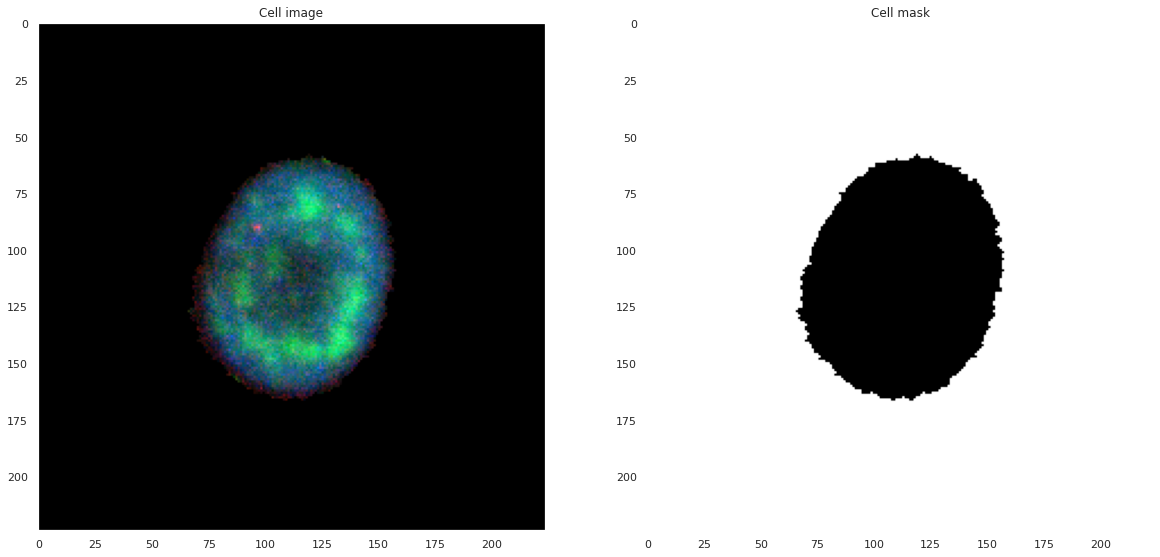


Cell targets: [4.36084367e+01 1.25531975e+02 2.55611784e+01 5.15777665e+01
 1.34959072e+02 5.87037672e+01 6.15669790e+01 5.76231849e+01
 5.61851297e+01 5.79024811e+01 4.43467967e+00 2.26160054e+02
 4.39586512e+01 4.52643347e+01 9.49160673e+01 8.29406185e+01
 7.00857754e+01 3.25679740e+01 5.38681296e+01 4.02544584e+01
 1.73007170e+02 3.21035363e+01 5.41245557e+01 1.63894812e+02
 1.20498010e+02 3.33854168e+02 1.52936419e+01 7.08655086e+01
 2.03578450e+02 4.97414804e+01 2.95241283e+02 1.96982726e+02
 1.10882853e+01 9.40846178e+00 2.08591419e+00 3.66162873e+02
 9.27432520e+03 1.15189896e+04]



In [12]:
cell_id = np.random.choice(metadata_df['mapobject_id_cell'].values)
file = os.path.join(output_data_path, str(cell_id)+'.npz')
cell = np.load(file)
cell_img = cell['img']
cell_img = cell_img / np.max(cell_img, axis=(0,1))
cell_mask = cell['mask']
cell_targets = cell['targets']

print('Cell image shape: {}\n'.format(cell_img.shape))
print('Cell mask shape: {}\n'.format(cell_mask.shape))
print('Cell target shape: {}\n'.format(cell_targets.shape))

# Now take a look into its image
plt.figure(figsize=(2 * 10,10))
plt.subplot(1,2,1)
plt.imshow(cell_img[:,:,10:13],
           cmap=plt.cm.PiYG,
           vmin=0, vmax=1,
           aspect='equal'
          )
plt.title('Cell image')
plt.grid(False)
plt.subplot(1,2,2)
plt.imshow(cell_mask,
           cmap=plt.cm.Greys,
           vmin=0, vmax=1,
           aspect='equal'
          )
plt.title('Cell mask')
plt.grid(False)
plt.show()

print('\nCell targets: {}\n'.format(cell_targets))

logging.info('\n\nPREPROCESSING FINISHED!!!!----------------------')